In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

shape_path = 'cb_2018_us_state_20m.shp'

shape = gpd.read_file(shape_path)
print(shape.head())

  STATEFP   STATENS     AFFGEOID GEOID STUSPS          NAME LSAD  \
0      24  01714934  0400000US24    24     MD      Maryland   00   
1      19  01779785  0400000US19    19     IA          Iowa   00   
2      10  01779781  0400000US10    10     DE      Delaware   00   
3      39  01085497  0400000US39    39     OH          Ohio   00   
4      42  01779798  0400000US42    42     PA  Pennsylvania   00   

          ALAND       AWATER  \
0   25151100280   6979966958   
1  144661267977   1084180812   
2    5045925646   1399985648   
3  105828882568  10268850702   
4  115884442321   3394589990   

                                            geometry  
0  MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...  
1  POLYGON ((-96.62187 42.77925, -96.57794 42.827...  
2  POLYGON ((-75.77379 39.72220, -75.75323 39.757...  
3  MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...  
4  POLYGON ((-80.51989 40.90666, -80.51964 40.987...  


In [2]:
shape = shape.dropna()
shape = shape[~shape['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

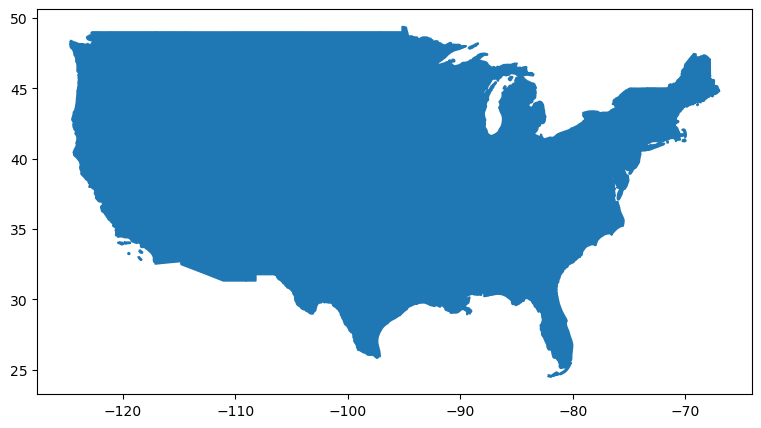

In [3]:
ax = shape.boundary.plot(figsize=(10, 5))
shape.plot(ax=ax, legend=True)

plt.show()

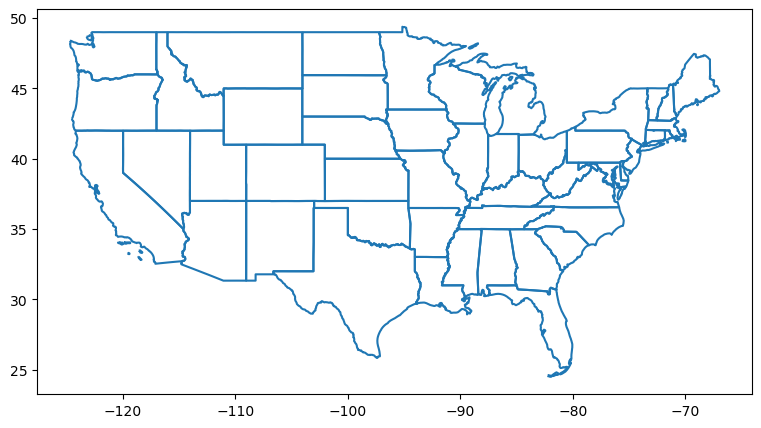

In [4]:
shape.boundary.plot(figsize=(10, 5))
plt.show()

In [5]:
pd_cities = pd.read_csv('test_data_2.csv')
cities = gpd.GeoDataFrame(
    pd_cities, geometry=gpd.points_from_xy(pd_cities.Longitude, pd_cities.Latitude))
cities.crs = 'EPSG:4326'
cities = cities.to_crs(shape.crs)

cities.head()

,Latitude,Longitude,geometry
0,33.60094,-86.95611,POINT (-86.95611 33.60094)


In [9]:
# cities dataframe treatment

uscities = pd.read_csv('uscities.csv')

uscities = uscities[["city", "state_id", "lat", "lng"]]

uscities.head()

,city,state_id,lat,lng
0,City of Industry,CA,34.0050,-117.939
1,Avon,CT,41.7944,-72.8578
2,Branford,CT,41.2778,-72.7997
3,Cromwell,CT,41.5950,-72.6453
4,East Windsor,CT,41.9167,-72.5578


In [11]:
# checking cities btw the two df (uscities and modified fandom)

df = pd.read_csv(r'C:\Users\inesn\Documents\Mines\2A\TR\econometrics\data_collection\plein_de_data\fandom_traitées.csv', parse_dates = ["Opening_date", "Closing_date"])

n_tot = 0
for state in df.State.unique():
    for city in df[df.State == state].Town.unique():
        if city not in uscities[uscities.state_id == state].city.unique() :
            n_tot+=1
print(n_tot)

0


In [73]:
df = pd.read_csv(r'C:\Users\inesn\Documents\Mines\2A\TR\econometrics\data_collection\plein_de_data\fandom_traitées.csv', parse_dates = ["Opening_date", "Closing_date"])

#modifying fandom df

#Store_id,State,Town,Street,Category,Opening_date,Closing_date

#creating boolean columns for entry/exit in 2016 (no entry and exit in 2016 for a single store)
df['opened_2016'] = (df.Opening_date>='2016-01-31')&(df.Opening_date<'2017-01-31')
df['closed_2016'] = (df.Closing_date>='2016-01-31')&(df.Closing_date<'2017-01-31')

#keeping only stores with entry/exit in 2016
df = df[df.opened_2016 | df.closed_2016]
df.describe()


,County_fips,Town_lat
count,114.000000,114.000000
mean,29291.000000,33.658012
std,17691.069885,4.712336
min,1069.000000,26.029300
25%,12095.000000,30.129025
50%,34025.000000,33.565700
75%,48028.500000,35.948700
max,51820.000000,58.454600


In [78]:
#designing the red-orange-green color code

df2 = df.groupby(['Town','State'])['opened_2016'].count().rename('opened_2016_city').to_frame()
#df3 = df.groupby(['Town','State'])['closed_2016'].any().rename('closed_2016_city').to_frame()
#df4 = df2.merge(df3, how = "outer", on = ['Town','State'])
#df4['opened_and_closed_2016_city']=df4.opened_2016_city & df4.closed_2016_city
#df4.head()
df2.head()

,,opened_2016_city
Town,State,
Abilene,TX,1
Abingdon,VA,1
Adel,GA,1
Alamogordo,NM,1
Aurora,IL,1


In [76]:
df5 = df4.merge(df, how = "outer", on = ['Town','State'])
df5=df5[['Town','State','opened_2016_city','closed_2016_city','opened_and_closed_2016_city']]
#aggregation_functions = {'Town': 'first', 'State': 'second', 'opened_2016_city': 'third' ,'closed_2016_city': 'fourth','opened_and_closed_2016_city': 'fifth','town': 'sum'}
#df_new = df5.groupby(df5[['Town','State']]).aggregate(aggregation_functions)
df5.describe()

,Town,State,opened_2016_city,closed_2016_city,opened_and_closed_2016_city
count,114,114,114,114,114
unique,99,27,2,2,1
top,San Antonio,TX,True,False,False
freq,5,24,108,108,114


In [39]:
#merging the 2 dfs

map_data = pd.merge(df5, uscities,  how='inner', left_on=['Town','State'], right_on = ['city','state_id'])

#removing unnecessary columns ('Town', 'State')

map_data = map_data[['city','lat','lng','opened_2016_city','closed_2016_city','opened_and_closed_2016_city']]

def colors(x):
    if x == 1 :
        return 'g'
    if x == 2 :
        return 'r'
    return 'b'

colors_v = np.vectorize(colors)

map_data['value']= 1*map_data['opened_2016_city']+2*map_data['closed_2016_city']+3*map_data['opened_and_closed_2016_city']
map_data['color']=colors_v(map_data['value'])
map_data.describe()



,lat,value
count,313.000000,313.000000
mean,34.163656,1.511182
std,3.983202,0.665570
min,25.997500,1.000000
25%,31.577600,1.000000
50%,34.114100,1.000000
75%,35.975100,2.000000
max,58.454600,6.000000


In [205]:
#base = shape.boundary.plot(figsize=(10, 5))

#geo_map_data.plot(ax=base, marker='o', color=geo_map_data['color'], markersize=1);
def colourmap(value):
    return value

#geo_map_data.explore()

### New code for the map

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv(r'C:\Users\inesn\Documents\Mines\2A\TR\econometrics\data_collection\plein_de_data\fandom_traitées.csv', parse_dates = ["Opening_date", "Closing_date"])

In [3]:
# cities dataframe treatment

uscities = pd.read_csv('uscities.csv')

uscities = uscities[["city", "state_id", "lat", "lng"]]

In [4]:
#creating boolean columns for entry/exit in 2016 (no entry and exit in 2016 for a single store)
df['opened_2016'] = (df.Opening_date>='2015-01-31')&(df.Opening_date<='2017-01-31')
df['closed_2016'] = (df.Closing_date>='2015-01-31')&(df.Closing_date<='2017-01-31')

In [5]:
#keeping only stores with entry/exit in 2016
df = df[df.opened_2016 | df.closed_2016]
df.describe()

,County_fips,Town_lat
count,455.000000,455.000000
mean,29033.931868,34.225134
std,17433.787812,3.885518
min,1009.000000,25.997500
25%,12099.000000,31.824800
50%,29223.000000,34.371800
75%,47152.000000,36.185750
max,56021.000000,58.454600


In [27]:
#designing the red-orange-green color code

#assuming that there isn't 2 cities with same name in same state in our database
df_test = df.groupby(['Town','State'])['Store_id'].count().rename("Stores' changes").to_frame()
df_test.describe()

,Stores' changes
count,383.000000
mean,1.187990
std,0.575378
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,7.000000


array([[<AxesSubplot: title={'center': "Stores' changes"}>]], dtype=object)

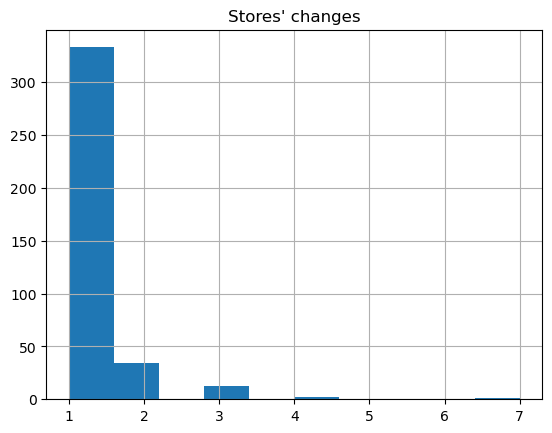

In [28]:
df_test.hist()

In [29]:
df.describe()

,County_fips,Town_lat
count,455.000000,455.000000
mean,29033.931868,34.225134
std,17433.787812,3.885518
min,1009.000000,25.997500
25%,12099.000000,31.824800
50%,29223.000000,34.371800
75%,47152.000000,36.185750
max,56021.000000,58.454600


In [30]:
#designing the red-orange-green color code
df2 = df.groupby(['Town','State'])['opened_2016'].any().rename('opened_2016_city').to_frame()
df2.describe()

,opened_2016_city
count,383
unique,2
top,True
freq,254


In [31]:
df3 = df.groupby(['Town','State'])['closed_2016'].any().rename('closed_2016_city').to_frame()
df3.describe()

,closed_2016_city
count,383
unique,2
top,False
freq,239


In [32]:
df4 = df2.merge(df3, how = "outer", on = ['Town','State'])
df4 = df4.merge(df_test, how = "outer", on = ['Town','State'])
df4.head()

,,opened_2016_city,closed_2016_city,Stores' changes
Town,State,,,
Abbeville,AL,False,True,1
Abilene,TX,True,False,1
Abingdon,VA,True,False,1
Adel,GA,True,False,1
Alabaster,AL,True,False,1


In [33]:
def legend(x):
    if x == 1 :
        return 'Entry only'
    if x == 2 :
        return 'Exit only'
    return 'Both entry and exit'

legend_v = np.vectorize(legend)
df4['Walmart store entry or/and exit (2016, per city)']= legend_v(1*df4['opened_2016_city']+2*df4['closed_2016_city'])
df4.describe()

,Stores' changes
count,383.000000
mean,1.187990
std,0.575378
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,7.000000


In [45]:
map_data = pd.merge(df4, uscities,  how='inner', left_on=['Town','State'], right_on = ['city','state_id'])
map_data.head()
#df5=df5[['Town','State','opened_2016_city','closed_2016_city','opened_and_closed_2016_city']]
map_data = map_data.rename(columns={'city': 'City', 'state_id': 'State', 'lat' : 'Latitude', 'lng' : 'Longitude'})
map_data.head()

,opened_2016_city,closed_2016_city,Stores' changes,"Walmart store entry or/and exit (2016, per city)",City,State,Latitude,Longitude
0,False,True,1,Exit only,Abbeville,AL,31.5664,-85.2528
1,True,False,1,Entry only,Abilene,TX,32.4543,-99.7384
2,True,False,1,Entry only,Abingdon,VA,36.7090,-81.9713
3,True,False,1,Entry only,Adel,GA,31.1264,-83.4229
4,True,False,1,Entry only,Alabaster,AL,33.2198,-86.8225


In [47]:
geo_map_data = gpd.GeoDataFrame(
    map_data, geometry=gpd.points_from_xy(map_data.Longitude, map_data.Latitude))
geo_map_data.crs = 'EPSG:4326'
#geo_map_data = geo_map_data.to_crs(shape.crs)
geo_map_data.head()

,opened_2016_city,closed_2016_city,Stores' changes,"Walmart store entry or/and exit (2016, per city)",City,State,Latitude,Longitude,geometry
0,False,True,1,Exit only,Abbeville,AL,31.5664,-85.2528,POINT (-85.25280 31.56640)
1,True,False,1,Entry only,Abilene,TX,32.4543,-99.7384,POINT (-99.73840 32.45430)
2,True,False,1,Entry only,Abingdon,VA,36.7090,-81.9713,POINT (-81.97130 36.70900)
3,True,False,1,Entry only,Adel,GA,31.1264,-83.4229,POINT (-83.42290 31.12640)
4,True,False,1,Entry only,Alabaster,AL,33.2198,-86.8225,POINT (-86.82250 33.21980)


In [48]:
geo_map_data.explore(column='Walmart store entry or/and exit (2016, per city)', tooltip = ["Stores' changes","City","State","Latitude","Longitude"], cmap=["blue","green","red"], 
                     style_kwds={"style_function": lambda x: {"radius": x["properties"]["Stores' changes"]*2}})

For each city where there is at least an entry or exit, the circle's radius is proportional to the number of stores' openings and closings (stores' changes) in the city for year 2016 (from January, 1, 2016 to January 31, 2017). This number is displayed when hovering over the circle on the map.

### Brouillon

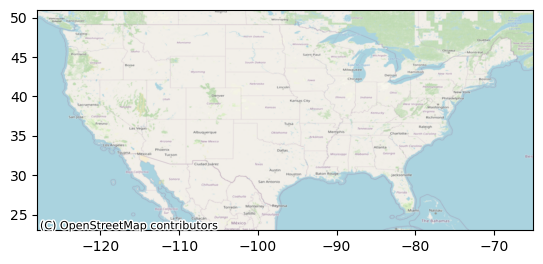

In [14]:
import geopandas as gpd
import contextily as cx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as pa
from matplotlib.lines import Line2D

long_min = - 128
long_max = -65
lat_min = 23
lat_max = 51

#collecte de la dataframe...
df = pd.read_csv('test_data.csv', parse_dates = ["Opening_date", "Closing_date"])
df = df[['Latitude', 'Longitude', 'State']]
df.head()

#conversion en geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs='EPSG:4326')

#création des couleurs/tailles de points
def couleur(a): # couleur d'un point du graphique en fonction de a la date du séisme en km
    if a == "opened":
        return 'purple'
    elif a == "closed":
        return 'blue'
    elif a == "opened-closed":
        return 'green'
    return 'yellow'

vcouleur = np.vectorize(couleur)

color=vcouleur(df['State'])

fig, ax = plt.subplots() #gdf.plot(kind='scatter', y='Latitude', x='Longitude', s=magn_2, c=prof, edgecolors='k', linewidth = 0.6)
ax.set_xlim(long_min, long_max)
ax.set_ylim(lat_min, lat_max)
cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.OpenStreetMap.Mapnik) #OpenStreetMap.Mapnik

line1 = Line2D(range(1), range(1), color="purple", marker='o', markerfacecolor="purple")
line2 = Line2D(range(1), range(1), color="blue", marker='o',markerfacecolor="blue")
line3 = Line2D(range(1), range(1), color="cyan", marker='o', markerfacecolor="cyan")
line4 = Line2D(range(1), range(1), color="green", marker='o',markerfacecolor="green")
line5 = Line2D(range(1), range(1), color="yellow", marker='o',markerfacecolor="yellow")
#plt.legend((line1,line2,line3,line4, line5),('< 2 km', '2-4 km', '4-6 km', '6-8 km', '8-10 km'),numpoints=1, loc='lower right',title = 'Profondeur',borderpad = 0.5, labelspacing = 0.5)

plt.show()

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as pa
from matplotlib.lines import Line2D

long_min = - 128
long_max = -65
lat_min = 23
long_max = 51

#collecte de la dataframe...
df = pd.read_csv('test_data.csv', parse_dates = ["Opening_date", "Closing_date"])

df.head()

,Store_id,State,Town,Street,Category,Opening_date,Closing_date,Latitude,Longitude,State
0,1158,AL,Adamsville,2473 Hackworth Rd.,Walmart Supercenter,1988-03-01,NaT,33.60094,-86.95611,"""opened"""


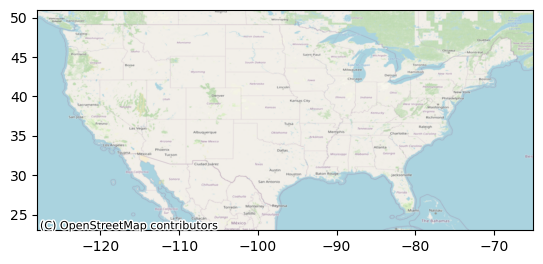

In [16]:
import geopandas as gpd
import contextily as cx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as pa
from matplotlib.lines import Line2D

long_min = - 128
long_max = -65
lat_min = 23
lat_max = 51

#collecte de la dataframe...
df = pd.read_csv('test_data.csv', parse_dates = ["Opening_date", "Closing_date"])
df = df[['Latitude', 'Longitude', 'State']]
df.head()

#conversion en geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs='EPSG:4326')

fig, ax = plt.subplots() #gdf.plot(kind='scatter', y='Latitude', x='Longitude', s=magn_2, c=prof, edgecolors='k', linewidth = 0.6)
ax.set_xlim(long_min, long_max)
ax.set_ylim(lat_min, lat_max)
cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.OpenStreetMap.Mapnik) #OpenStreetMap.Mapnik

plt.show()

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

#uscities df
uscities = pd.read_csv('uscities.csv')
uscities = uscities[["city", "state_id", "lat", "lng"]]

#our df
df = pd.read_csv(r'C:\Users\inesn\Documents\Mines\2A\TR\econometrics\data_collection\plein_de_data\fandom_traitées.csv', parse_dates = ["Opening_date", "Closing_date"])

#creating boolean columns for entry/exit in 2016 (no entry and exit in 2016 for a single store)
df['opened_2016'] = (df.Opening_date>='2016-01-31')&(df.Opening_date<'2017-01-31')
df['closed_2016'] = (df.Closing_date>='2016-01-31')&(df.Closing_date<'2017-01-31')

#keeping only stores with entry/exit in 2016
df = df[df.opened_2016 | df.closed_2016]

#designing the red-orange-green color code and the size code
#assuming that there isn't 2 cities with same name in same state in our database
df_test = df.groupby(['Town','State'])['Store_id'].count().rename('count').to_frame()
df2 = df.groupby(['Town','State'])['opened_2016'].any().rename('opened_2016_city').to_frame()
df3 = df.groupby(['Town','State'])['closed_2016'].any().rename('closed_2016_city').to_frame()
df4 = df2.merge(df3, how = "outer", on = ['Town','State'])
df4 = df4.merge(df_test, how = "outer", on = ['Town','State'])
def legend(x):
    if x == 1 :
        return 'Entry'
    if x == 2 :
        return 'Exit'
    return 'Both'
legend_v = np.vectorize(legend)
df4['Walmart entry or/and exit (2016, per city)']= legend_v(1*df4['opened_2016_city']+2*df4['closed_2016_city'])
map_data = pd.merge(df4, uscities,  how='inner', left_on=['Town','State'], right_on = ['city','state_id'])

#plotting the map
geo_map_data = gpd.GeoDataFrame(
    map_data, geometry=gpd.points_from_xy(map_data.lng, map_data.lat))
geo_map_data.crs = 'EPSG:4326'
geo_map_data.explore(column='Walmart entry or/and exit (2016, per city)', cmap=["blue","green","red"], 
                     style_kwds={"style_function": lambda x: {"radius": x["properties"]["count"]*2}})